#Sentiment analysis: NLP Sarcasm Detection
In this work, we designed the Bidirectional Long Short Term memory (LSTM) networks model to predic whether there exits sarcasm in the News healines. Our designed model has comparable validation accruacy as the Fine-tune BERT model but has much faster training speed (30x).

In [18]:
###Get the data online
!wget --no-check-certificate https://storage.googleapis.com/learning-datasets/sarcasm.json -O /tmp/alldata.json

--2023-08-31 05:16:32--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.187.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/alldata.json’

/tmp/alldata.json   100%[===================>]   5.38M  6.85MB/s    in 0.8s    

2023-08-31 05:16:33 (6.85 MB/s) - ‘/tmp/alldata.json’ saved [5643545/5643545]



In [21]:
import json
import tensorflow as tf

In [22]:
with open("/tmp/alldata.json", 'r') as f:
    alldata = json.load(f)

headline_list = []
label_list = []
for i in alldata:
    headline_list.append(i['headline'])
    label_list.append(i['is_sarcastic'])

import numpy as np
#change the list to numpy list, easier for action in these lists.
headline_nplist= np.array(headline_list)
label_nplist = np.array(label_list)

In [23]:
# Pretreatment of the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Shuffle the data and split the training and testing data according to the user defined ratio
def pretreat_and_token_data_withpad(headline_nplist, label_nplist, train_ratio=0.8):
    num_sample = len(headline_nplist)
    train_size = int(train_ratio * num_sample)
    #test_size = num_sample - train_size

    ##shuffle the list data
    shuffle_idx = np.random.permutation(len(headline_nplist))
    headline_nplist = headline_nplist[shuffle_idx]
    label_nplist = label_nplist[shuffle_idx]

    train_headline_nplist = headline_nplist[:train_size]
    test_headline_nplist = headline_nplist[train_size:]
    train_label_nplist = label_nplist[:train_size]
    test_label_nplist = label_nplist[train_size:]

    #train_max_length = max(len(seq) for seq in train_headline_nplist)
    #test_max_length = max(len(seq) for seq in test_headline_nplist)
    #max_length = max(train_max_length, test_max_length)

    max_length = 40 ## I didn't quantify the max length, use the max headline in the dataset instead.
    ##Tokenize the headline
    tokenizer = Tokenizer(oov_token="*****")
    tokenizer.fit_on_texts(train_headline_nplist)

    ##train data
    train_sequences_list = tokenizer.texts_to_sequences(train_headline_nplist)
    train_padded_sequences_list = pad_sequences(train_sequences_list)

    ##test data
    test_sequences_list = tokenizer.texts_to_sequences(test_headline_nplist)
    test_padded_sequences_list = pad_sequences(test_sequences_list, maxlen=max_length)
    return train_padded_sequences_list, train_label_nplist, test_padded_sequences_list, test_label_nplist, tokenizer, max_length

train_padded_sequences_list, train_label_nplist, test_padded_sequences_list, test_label_nplist, tokenizer, max_length = pretreat_and_token_data_withpad(headline_nplist, label_nplist, train_ratio=0.8)
print(train_padded_sequences_list.shape)
print(train_label_nplist.shape)

(21367, 40)
(21367,)


In [ ]:
### Set up for the BERT model

In [7]:
import tensorflow as tf

In [24]:
!pip install transformers
from transformers import TFBertForSequenceClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00


In [25]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from tensorflow.keras.optimizers import Adam

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy("accuracy")]
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-5), metrics=['accuracy'])

# Define EarlyStopping callback
earlyStop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Specify other training parameters
num_epochs = 10
batch_size = 32

# Fit the model
history = bert_model.fit(
    train_padded_sequences_list,
    train_label_nplist,
    validation_data=(test_padded_sequences_list, test_label_nplist),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[earlyStop]
)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
668/668 [==============================] - 264s 313ms/step - loss: 0.6889 - accuracy: 0.5535 - val_loss: 0.6833 - val_accuracy: 0.5640
Epoch 2/10
668/668 [==============================] - 201s 301ms/step - loss: 0.5897 - accuracy: 0.6646 - val_loss: 0.4584 - val_accuracy: 0.7963
Epoch 3/10
668/668 [==============================] - 198s 296ms/step - loss: 0.3710 - accuracy: 0.8427 - val_loss: 0.3788 - val_accuracy: 0.8375
Epoch 4/10
668/668 [==============================] - 203s 304ms/step - loss: 0.2604 - accuracy: 0.8954 - val_loss: 0.3473 - val_accuracy: 0.8521
Epoch 5/10
668/668 [==============================] - 203s 303ms/step - loss: 0.1824 - accuracy: 0.9342 - val_loss: 0.4569 - val_accuracy: 0.8416
Epoch 6/10
668/668 [==============================] - 202s 303ms/step - loss: 0.1224 - accuracy: 0.9584 - val_loss: 0.4614 - val_accuracy: 0.8508
Epoch 7/10
668/668 [==============================] - 202s 303ms/step - loss: 0.0860 - accuracy: 0.9724 - val_loss: 0.5529 -

Exception ignored in: <function _xla_gc_callback at 0x7fcfec239a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


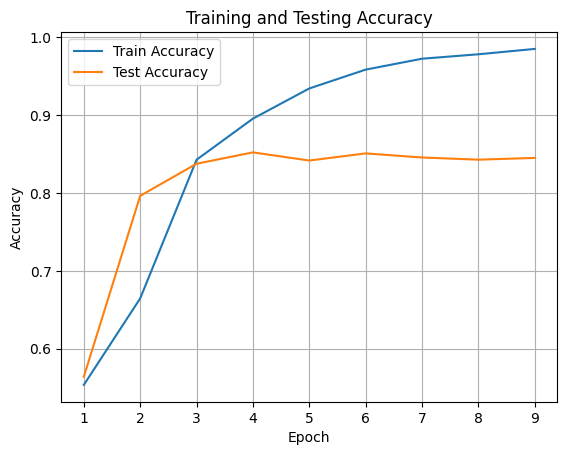

In [28]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

plt.plot(range(1,len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1,len(train_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Using the bidirectional Long Short Term Memory (LSTM) model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor = 'val_accuracy', patience=5, restore_best_weights=True)

num_epochs = 30
batch_size = 100
history = model.fit(train_padded_sequences_list, train_label_nplist, validation_data=(test_padded_sequences_list, test_label_nplist), epochs=num_epochs, batch_size=batch_size, callbacks=[earlyStop])


Epoch 1/30
214/214 [==============================] - 31s 106ms/step - loss: 0.7028 - accuracy: 0.7374 - val_loss: 0.4208 - val_accuracy: 0.8429
Epoch 2/30
214/214 [==============================] - 7s 32ms/step - loss: 0.4145 - accuracy: 0.8955 - val_loss: 1.2705 - val_accuracy: 0.7868
Epoch 3/30
214/214 [==============================] - 5s 25ms/step - loss: 0.2599 - accuracy: 0.9500 - val_loss: 0.4815 - val_accuracy: 0.8422
Epoch 4/30
214/214 [==============================] - 6s 26ms/step - loss: 0.1041 - accuracy: 0.9760 - val_loss: 0.5775 - val_accuracy: 0.8379
Epoch 5/30
214/214 [==============================] - 4s 17ms/step - loss: 0.0829 - accuracy: 0.9840 - val_loss: 0.5801 - val_accuracy: 0.8409
Epoch 6/30
214/214 [==============================] - 3s 16ms/step - loss: 0.0874 - accuracy: 0.9854 - val_loss: 0.7384 - val_accuracy: 0.8285


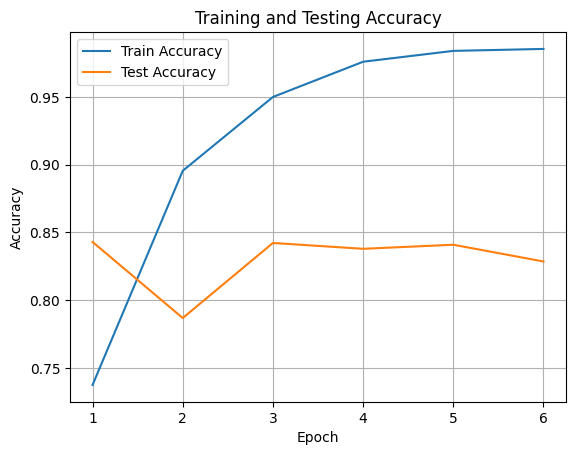

In [17]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

plt.plot(range(1,len(train_accuracy)+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1,len(train_accuracy)+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()